In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from google.colab import drive 
drive.mount("/content/drive/")

import os
os.chdir("/content/drive/My Drive/DSECOP/Colab Notebooks/")
!pwd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/DSECOP/Colab Notebooks


# Creating Pull Plots



In this notebook, we'll learn about residual plots and pull plots. We'll talk about the information that these plots provide us, and practice creating the plots ourselves.

## How can we gain more information about a model's goodness of fit?



In the previous notebook, we learned about the $\chi^2$ test statistic. There are two important limitations to this test statistic. The first is that the $\chi^2$ test only *really* works for categorical data, which "number of counts" only barely squeaks under. The second is that the $\chi^2$ test statistic is a single number, while we might want to evaluate our model fit at a specific part of our histogram (perhaps at the tails).

---



When we fit an analytical function to a dataset, we never expect there to be *perfect* agreement between the two. The discrepancies broadly fall into two categories:

1. **The dataset contains statistical fluctuations.** If we rolled a six-sided die six times, we would never expect to roll one of every number exactly once. Similarly, if we observe the decays of a radioactive sample, we expect the distribution to be Poissonian, but not *perfectly* so. We might also expect less-than-perfectly-precise detector performance to provide a good amount of statistical error.

2. **The chosen fit function is a poor one.** Fitting a linear fit function to quadratically distributed data should produce a fit that is obviously bad to the unaided eye. But sometimes, the a wrong model can be only subtly off. Can we trust our eyes to discriminate a quadratic function from a quartic one?

The first type of discrepancy is unavoidable in experimental processes. However, we might be able to diagnose and correct for the second type of discrepancy. Plotting the *residuals* of a fit can be a useful tool to this end.

To start off, let's practice what we learned before! 

**Activity**: Read in the dataset `geiger_counts_A.txt`. Histogram the dataset, then use `scipy.optimize.curve_fit` to fit the data to a Poisson and a Gaussian distribution. Plot the dataset and both fits on the same plot. 

In [ ]:
# First, histogram the data

dataset_location = "datasets/geiger_counts_A.txt"

def read_in_dataset(file_loc):

  with open(file_loc, "r") as infile:
    dataset = infile.read().split(",")
    num_clicks_per_minute = np.array([int(x) for x in dataset if x != " "])

    return num_clicks_per_minute

num_clicks_per_minute = read_in_dataset(dataset_location)

clicks_per_minute_bin_edges = np.linspace(-.5,30.5,32)
clicks_per_minute_bin_centers = 0.5*(clicks_per_minute_bin_edges[1:]+clicks_per_minute_bin_edges[:-1])


In [ ]:
# define the fit functions

def poisson(n, l, N):
  return [N*(l**x)*np.exp(-l) / np.math.factorial(x) for x in n]

def gaussian(n, mu, sigma, N):
  return [N*(1.0/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-mu)**2/sigma**2) for x in n]

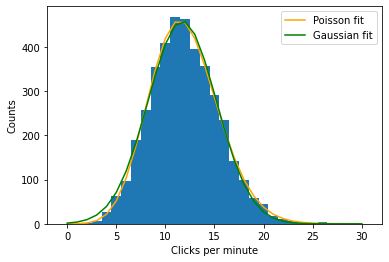

In [ ]:
num_clicks_per_minute_values, _ = np.histogram(num_clicks_per_minute, clicks_per_minute_bin_edges)

# 
poisson_popt, poisson_pcov = curve_fit(poisson, clicks_per_minute_bin_centers, num_clicks_per_minute_values)
gaussian_popt, gaussian_pcov = curve_fit(gaussian, clicks_per_minute_bin_centers, num_clicks_per_minute_values, p0=[10,10,100])

plt.figure()
plt.hist(num_clicks_per_minute, clicks_per_minute_bin_edges)
plt.plot(clicks_per_minute_bin_centers, poisson(clicks_per_minute_bin_centers, *poisson_popt), label = "Poisson fit", color = "orange")
plt.plot(clicks_per_minute_bin_centers, gaussian(clicks_per_minute_bin_centers, *gaussian_popt), label = "Gaussian fit", color = "green")
plt.xlabel("Clicks per minute")
plt.ylabel("Counts")
plt.legend()
plt.show()



## Defining the residuals of a fit



The name "residuals" should give some intuition about what we're looking for here -- they're the parts of our data that aren't perfectly captured by our fit function, or that are "left over".

Residuals are defined bin-wise, so they give us much more information than a single test statistic. The residual $r_i$ (defined for a given bin $b_i$) is defined as 

$$r_i = \textrm{actual value in bin } b_i - \textrm{fit value in bin } b_i.$$

How can we use residuals to discriminate between a model that is the best fit for a given dataset that contains many statistical fluctuations, vs. a model that is a poor fit? Statistical fluctuations are random, so they cause deviations of data from what's expected that would sometimes be greater than the underlying model, and sometimes less. In contrast, if the residuals for a given fit are always *positive*, this means that the fit function usually *underestimates* the data. This could be an indication that the fit function isn't great.

**Activity**: Plot the residuals of the Poisson and Gaussian fits to the dataset. It might be helpful to also plot a horizontal line at y = 0.

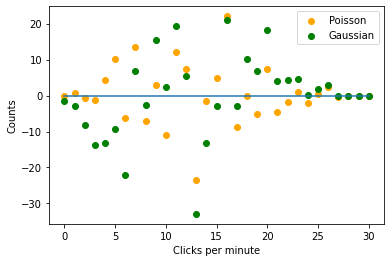

In [ ]:
poisson_fit_values = poisson(clicks_per_minute_bin_centers, *poisson_popt)
gaussian_fit_values = gaussian(clicks_per_minute_bin_centers, *gaussian_popt)

poisson_residuals = []
gaussian_residuals = []

for i in range(len(clicks_per_minute_bin_centers)):
  poisson_residuals.append(num_clicks_per_minute_values[i] - poisson_fit_values[i])
  gaussian_residuals.append(num_clicks_per_minute_values[i] - gaussian_fit_values[i])


plt.figure()
plt.scatter(clicks_per_minute_bin_centers, poisson_residuals, label = "Poisson", color = "orange")
plt.scatter(clicks_per_minute_bin_centers, gaussian_residuals, label = "Gaussian", color = "green")
plt.plot(clicks_per_minute_bin_centers, np.full(clicks_per_minute_bin_centers.shape, 0))
plt.xlabel("Clicks per minute")
plt.ylabel("Counts")
plt.legend()
plt.show()

## Scaling residuals to data: pull plots

Recall that for histograms of counts, the error for a given bin due to statistical fluctuations is $\sqrt{n}$, where $n$ is the number of counts in the bin. This means that we would expect the residuals to be larger for a bin with more counts, as there is a greater chance of getting a larger statistical fluctuation away from an expected value. Is there a similar quantity to residuals that normalizes for the number of counts in a given bin?

The scaled alternative to residuals are *pulls*. The pulls $p_i$ ) are defined as 

$$p_i = \frac{\textrm{actual value in bin } b_i - \textrm{fit value in bin } b_i}{\text{standard deviation associated with the fit value in bin }b_i}.$$

So the pull in a given bin is just the residual for that bin with a scaling factor to account for how large we would expect the statistical fluctuation in that bin to be. So while we expected the size of the residuals to vary based on the number of counts in the associated bin, we would expect the pulls to be on the order of 1 across all bins for a good fit.

**Activity**: Plot the pulls of the Poisson and Gaussian fits to the dataset. It might be helpful to also plot a horizontal line at y = 0. Based on the pull plot, make a statement about which fit is a better one to the observed data.

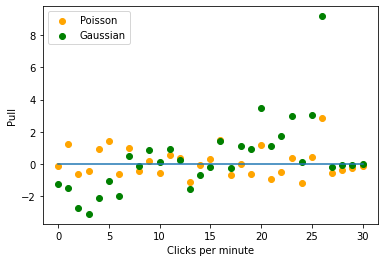

In [ ]:
poisson_pull = []
gaussian_pull = []

for i in range(len(clicks_per_minute_bin_centers)):
  poisson_pull.append((num_clicks_per_minute_values[i] - poisson_fit_values[i])/(np.sqrt(poisson_fit_values[i])))
  gaussian_pull.append((num_clicks_per_minute_values[i] - gaussian_fit_values[i])/(np.sqrt(gaussian_fit_values[i])))


plt.figure()
plt.scatter(clicks_per_minute_bin_centers, poisson_pull, label = "Poisson", color = "orange")
plt.scatter(clicks_per_minute_bin_centers, gaussian_pull, label = "Gaussian", color = "green")
plt.plot(clicks_per_minute_bin_centers, np.full(clicks_per_minute_bin_centers.shape, 0))
plt.xlabel("Clicks per minute")
plt.ylabel("Pull")
plt.legend()
plt.show()

**Activity**: Using `plt.subplots`, plot the (1) data and fit functions, and (2) pull plot using the same x-axis.

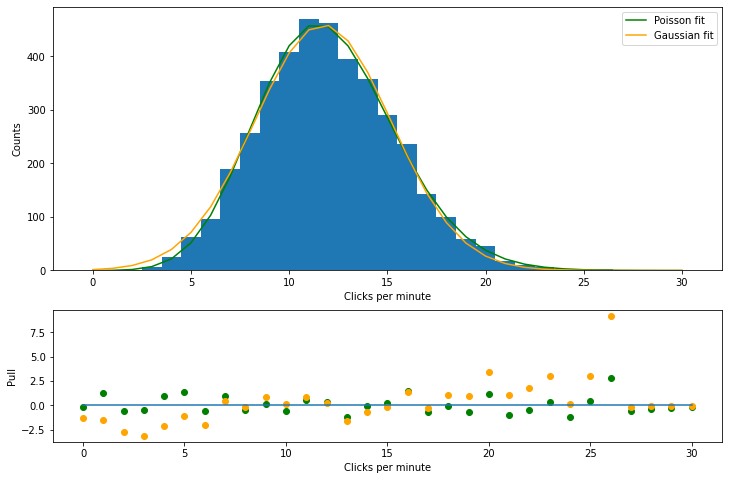

In [ ]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize = (12, 8))
axs[0].hist(num_clicks_per_minute, clicks_per_minute_bin_edges)
axs[0].plot(clicks_per_minute_bin_centers, poisson(clicks_per_minute_bin_centers, *poisson_popt), color = "green", label = "Poisson fit")
axs[0].plot(clicks_per_minute_bin_centers, gaussian(clicks_per_minute_bin_centers, *gaussian_popt), color = "orange", label = "Gaussian fit")
axs[0].set_xlabel("Clicks per minute")
axs[0].set_ylabel("Counts")
axs[0].legend()

axs[1].scatter(clicks_per_minute_bin_centers, poisson_pull, color = "green", label = "Poisson")
axs[1].scatter(clicks_per_minute_bin_centers, gaussian_pull, color = "orange", label = "Gaussian")
axs[1].plot(clicks_per_minute_bin_centers, np.full(clicks_per_minute_bin_centers.shape, 0))
axs[1].set_xlabel("Clicks per minute")
axs[1].set_ylabel("Pull")

fig.show()

*Notebook finished*